# League of Legends 10 Minute Game Analysis

This notebook explores the 


Note: Elite monsters = Dragons + Heralds

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 
import scipy

# sklearn preprocessing/scoring
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, KFold

#sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 50)

In [93]:
lol = pd.read_csv("./high_diamond_ranked_10min.csv", index_col=0)

In [94]:
lol.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
gameId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [95]:
lol.describe()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
count,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,0.499038,22.288288,2.824881,0.504808,6.183925,6.137666,6.645106,0.549954,0.361980,0.187974,0.051422,16503.455512,6.916004,17928.110133,216.699565,50.509667,14.414111,-33.620306,21.669956,1650.345551,22.367952,2.723150,0.495192,6.137666,6.183925,6.662112,0.573135,0.413098,0.160036,0.043021,16489.041401,6.925316,17961.730438,217.349226,51.313088,-14.414111,33.620306,21.734923,1648.904140
std,0.500024,18.019177,2.174998,0.500002,3.011028,2.933818,4.064520,0.625527,0.480597,0.390712,0.244369,1535.446636,0.305146,1200.523764,21.858437,9.898282,2453.349179,1920.370438,2.185844,153.544664,18.457427,2.138356,0.500002,2.933818,3.011028,4.060612,0.626482,0.492415,0.366658,0.216900,1490.888406,0.305311,1198.583912,21.911668,10.027885,2453.349179,1920.370438,2.191167,149.088841
min,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10730.000000,4.600000,10098.000000,90.000000,0.000000,-10830.000000,-9333.000000,9.000000,1073.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11212.000000,4.800000,10465.000000,107.000000,4.000000,-11467.000000,-8348.000000,10.700000,1121.200000
25%,0.000000,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,15415.500000,6.800000,17168.000000,202.000000,44.000000,-1585.500000,-1290.500000,20.200000,1541.550000,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,15427.500000,6.800000,17209.500000,203.000000,44.000000,-1596.000000,-1212.000000,20.300000,1542.750000
50%,0.000000,16.000000,3.000000,1.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,16398.000000,7.000000,17951.000000,218.000000,50.000000,14.000000,-28.000000,21.800000,1639.800000,16.000000,2.000000,0.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,16378.000000,7.000000,17974.000000,218.000000,51.000000,-14.000000,28.000000,21.800000,1637.800000
75%,1.000000,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,0.000000,0.000000,17459.000000,7.200000,18724.000000,232.000000,56.000000,1596.000000,1212.000000,23.200000,1745.900000,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,0.000000,0.000000,17418.500000,7.200000,18764.500000,233.000000,57.000000,1585.500000,1290.500000,23.300000,1741.850000
max,1.000000,250.000000,27.000000,1.000000,22.000000,22.000000,29.000000,2.000000,1.000000,1.000000,4.000000,23701.000000,8.000000,22224.000000,283.000000,92.000000,11467.000000,8348.000000,28.300000,2370.100000,276.000000,24.000000,1.000000,22.000000,22.000000,28.000000,2.000000,1.000000,1.000000,2.000000,22732.000000,8.200000,22269.000000,289.000000,92.000000,10830.000000,9333.000000,28.900000,2273.200000


# Exploratory Data Analysis

Let's start by looking at each feature's distribution. This will give us an idea of any outliers or class balance problems.

In [96]:
# Check for any missing values
lol.isna().sum().sum()

0

In [97]:
# value counts for the target variable
lol["blueWins"].value_counts()

0    4949
1    4930
Name: blueWins, dtype: int64

In [98]:
# value counts for the other binary variable, blueFirstBlood
lol["blueFirstBlood"].value_counts()

1    4987
0    4892
Name: blueFirstBlood, dtype: int64

Seems like the classes for binary variables are balanced and we have no missing values.

In [99]:
lol.columns

Index(['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood',
       'blueKills', 'blueDeaths', 'blueAssists', 'blueEliteMonsters',
       'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold',
       'blueAvgLevel', 'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
       'redFirstBlood', 'redKills', 'redDeaths', 'redAssists',
       'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redAvgLevel', 'redTotalExperience',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff',
       'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin'],
      dtype='object')

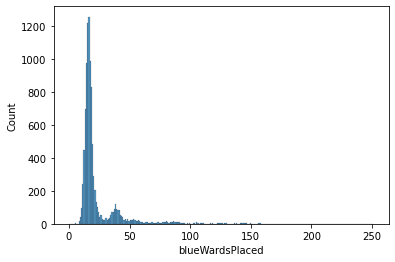

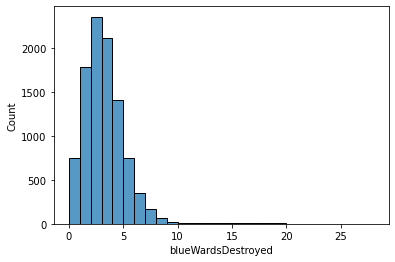

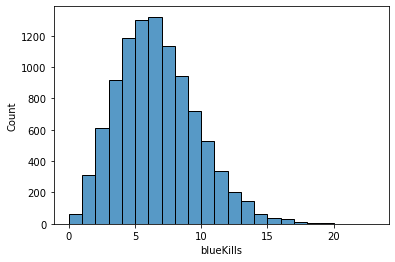

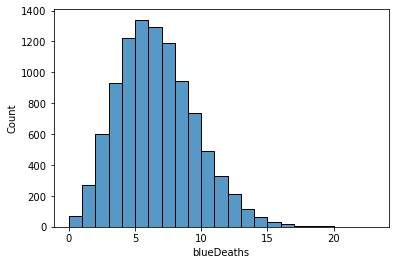

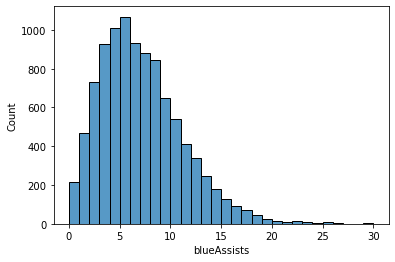

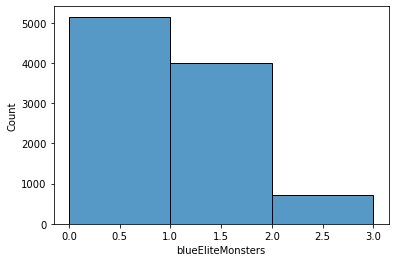

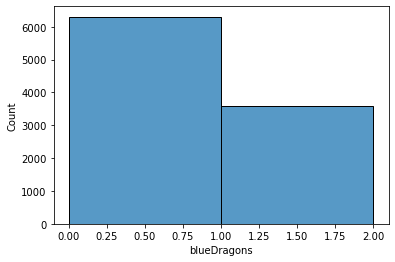

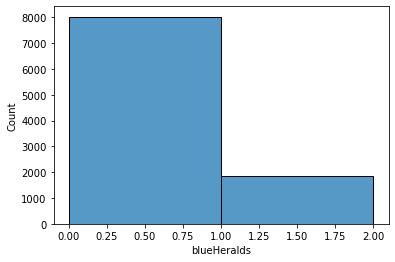

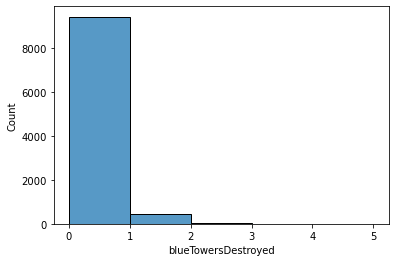

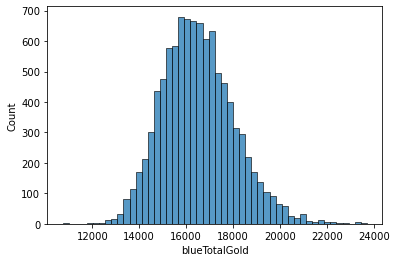

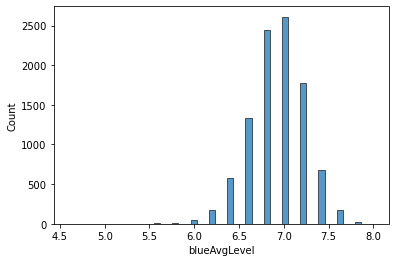

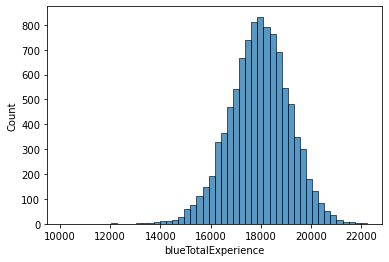

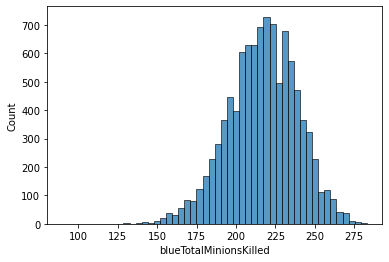

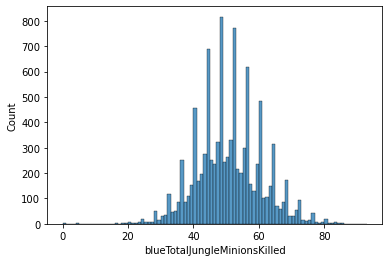

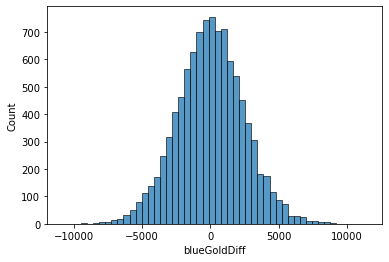

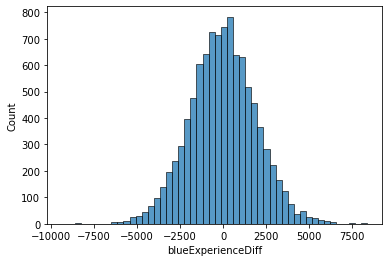

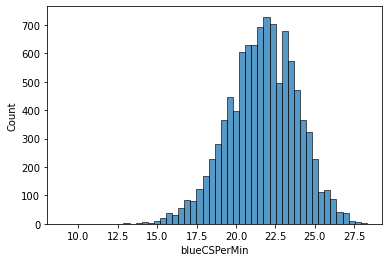

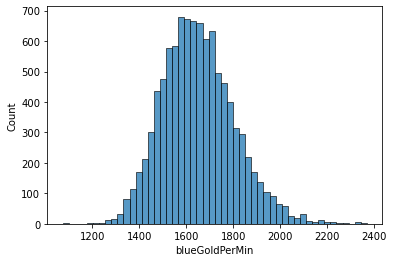

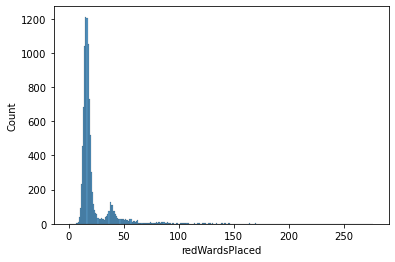

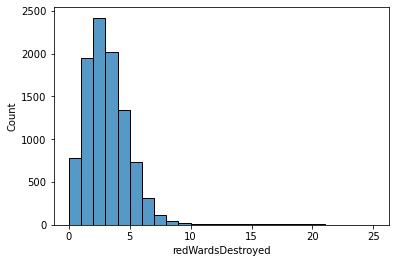

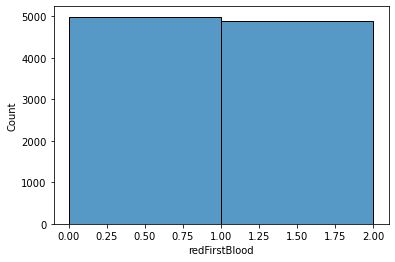

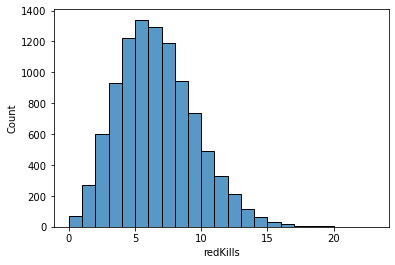

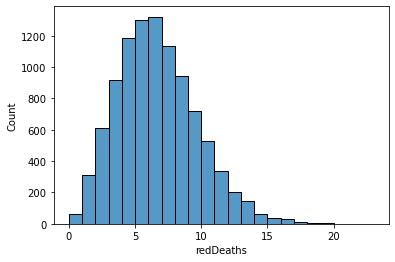

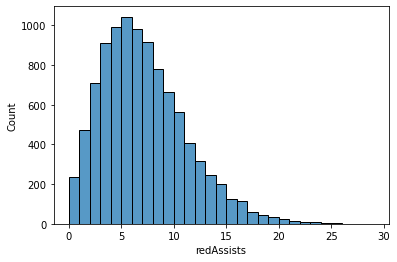

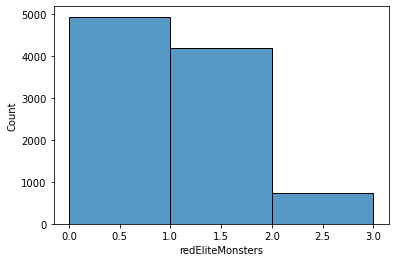

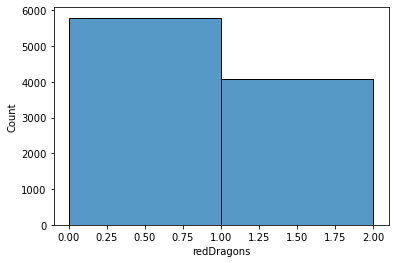

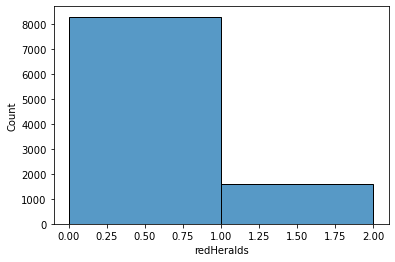

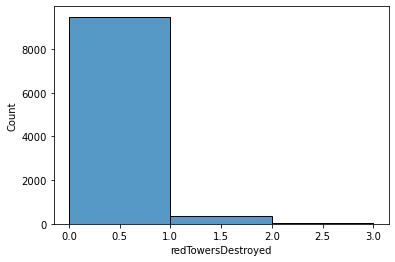

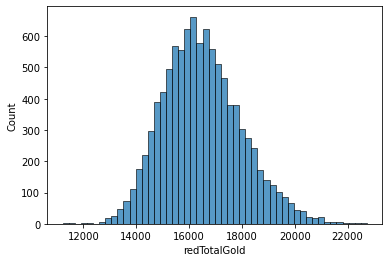

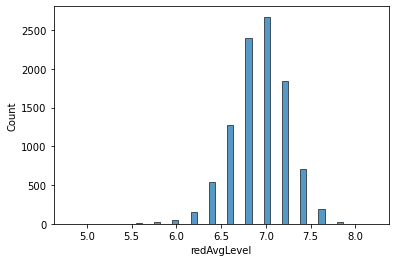

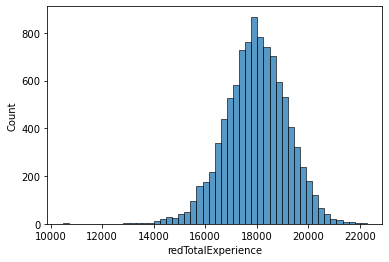

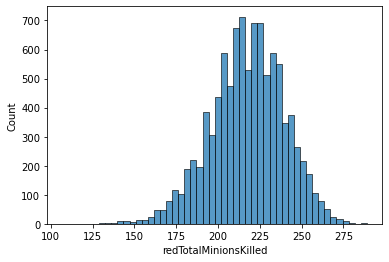

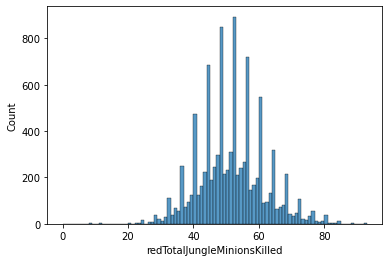

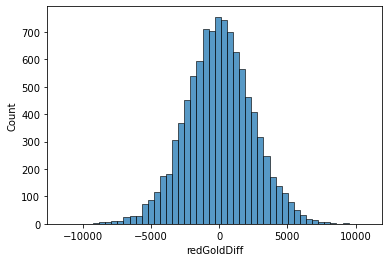

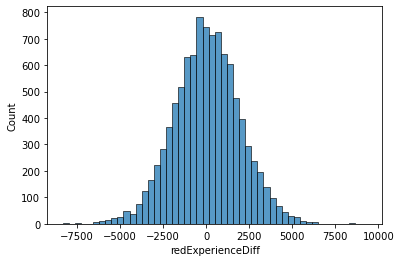

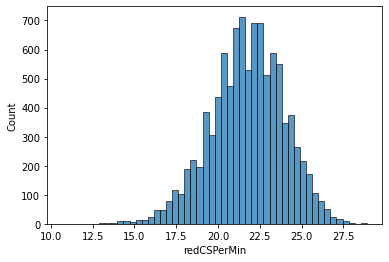

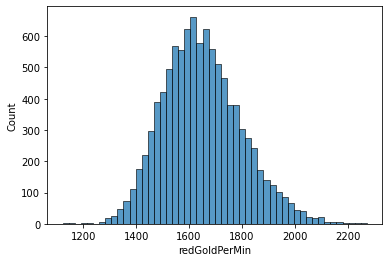

In [100]:
# look at histograms of each variable
def make_histograms(df: pd.DataFrame): 
    for col in df.columns:
        if df[col].dtype == 'int64':
            sns.histplot(df[col], bins=np.arange(0, np.max(df[col])+2, 1))
        else:
            sns.histplot(df[col], bins=50)
        plt.show()  

# ad-hoc convert datatypes so a reasonable number of bins will be created
make_histograms(
    lol.drop(["blueWins", "blueFirstBlood"], axis=1).\
        astype({'blueTotalGold': np.float64, 
                'redTotalGold': np.float64,
                'blueTotalExperience': np.float64,
                'redTotalExperience': np.float64,
                'blueGoldDiff': np.float64,
                'redGoldDiff': np.float64,
                'blueExperienceDiff': np.float64,
                'redExperienceDiff': np.float64,
                'blueTotalMinionsKilled': np.float64,
                'redTotalMinionsKilled': np.float64,
               })
)

Scanning the histograms tells us that the only features that seem to have outliers have to do with wards.
Some games show 150+ wards in the first 10 minutes, or 15 wards per minute.
There are five players on a team, so each player is placing upwards of 3 wards per minute. While not impossible, this is certainly an agressive warding strategy. 
The maximum number of wards is 250; that would mean on average each player is placing 5 wards per minute!

You can place up to three wards at a time, and each ward lasts 2 minutes (unless destroyed beforehand). Assuming you are a diligent warder (and your enemies aren't destroying them), that means in the first 10 minutes you can place 15 wards, or 75 wards for a whole team. 
Using this heuristic, I will define an aggressive warding game as one where a team places twice as many as this amount, or more than 150 wards in the first 10 minutes. The reasoning behind doubling is to account for variability in the lifetime of a ward; most wards are found and destroyed, allowing you to place more than 3 wards every two minutes.
  


In [101]:
# number of aggressive warders 
aggressive_warders = (lol["blueWardsPlaced"] > 150) | (lol["redWardsPlaced"] > 150)
print(f"There are {aggressive_warders.sum()} aggressive warding games, or about {np.round(aggressive_warders.sum()/len(lol), 3)}% of games.")

There are 46 aggressive warding games, or about 0.005% of games.


Possible explanations for these aggressive warders (outliers) is that the Riot API counts wards from other sources. For example, the champion Fiddlesticks can obtain a trinket which lets him place more wards. This could account for the unusually high number of wards in some games, so I will leave the outliers in the dataset.
To deal with the heavy skew I will take the logarithm of this variable.

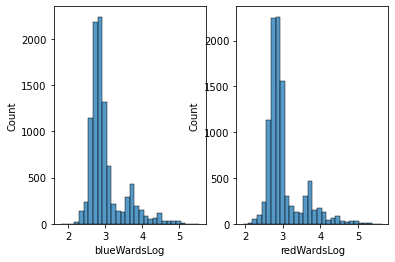

In [102]:
# take the logarithms of these variables. Adding 1 in case a game has zero wards placed.
lol["blueWardsLog"] = lol["blueWardsPlaced"].apply(lambda x: np.log(x+1))
lol["redWardsLog"] = lol["redWardsPlaced"].apply(lambda x: np.log(x+1))

# make a plot of them
fig, ax = plt.subplots(1, 2)

sns.histplot(lol["blueWardsLog"], ax=ax[0], bins=30)
sns.histplot(lol["redWardsLog"], ax=ax[1], bins=30)
plt.show()

## Removing Highly Correlated Features

Some of the variables are redundant. These are often the variables that are of the form "total ---" and "--- per minute."
Since each game is 10 minutes in this dataset, these columns are going to be multiples of each other.

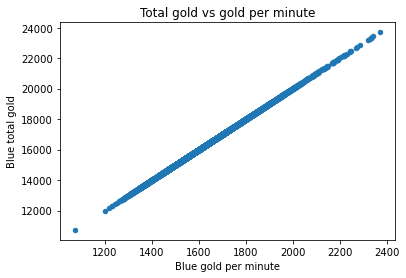

In [103]:
lol[["blueGoldPerMin", "blueTotalGold"]].plot.scatter(x="blueGoldPerMin", y="blueTotalGold")
plt.ylabel("Blue total gold")
plt.xlabel("Blue gold per minute")
plt.title("Total gold vs gold per minute")
plt.show()

In [104]:
# remove highly redundant features
corr_mat = lol.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))

# get columns to drop
cols_to_drop = [col for col in upper.columns if any(upper[col] > 0.99)]

# see which columns are highly correlated
corr_pairs = corr_mat.unstack().sort_values(ascending=False)
high_corrs = corr_pairs[corr_pairs > 0.95]
high_corrs.loc[(cols_to_drop, lol.columns.difference(cols_to_drop))]

blueCSPerMin       blueTotalMinionsKilled    1.0
blueGoldPerMin     blueTotalGold             1.0
redFirstBlood      blueFirstBlood            1.0
redKills           blueDeaths                1.0
redDeaths          blueKills                 1.0
redGoldDiff        blueGoldDiff              1.0
redExperienceDiff  blueExperienceDiff        1.0
redCSPerMin        redTotalMinionsKilled     1.0
redGoldPerMin      redTotalGold              1.0
dtype: float64

I will drop these columns since they perfectly correlate with other features, which will reduce the dimensionality of the dataset.

In [105]:
lol.drop(columns=cols_to_drop, inplace=True)

### Total Gold is Redundant

Based on my experience playing this game, the total gold should be determined by other features;
 minion kills/assists, champion kills, towers, and elite monsters all determine the amount of gold earned.
A simple linear model demonstrates this:

In [106]:
from sklearn.linear_model import LinearRegression

gold_fit = LinearRegression()
 
gold_subset = lol[["blueTotalGold", "blueTotalJungleMinionsKilled", "blueKills","blueAssists", "blueEliteMonsters", "blueDragons", "blueHeralds", "blueTowersDestroyed", "blueTotalMinionsKilled"]]

gold_fit.fit(X=gold_subset.iloc[:, 1:], y=gold_subset["blueTotalGold"])

# R^2 value
R2 = gold_fit.score(X=gold_subset.iloc[:, 1:], y=gold_subset["blueTotalGold"])
print(f"This linear model has R^2 = {np.round(R2, 2)}")

This linear model has R^2 = 0.94


The reason this isn't perfect has to do with nuances in the kill-reward system; killing a champion rewards less and less the more they are killed, and a simple linear model will fail to detect this.

Let's take take a further look at the residuals:

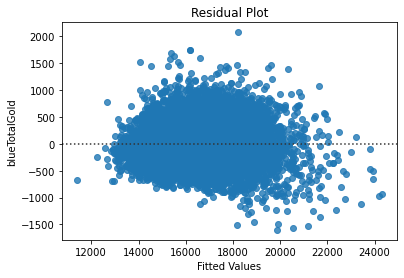

In [107]:
preds = gold_fit.predict(gold_subset.iloc[:, 1:])

sns.residplot(x=preds, y=gold_subset["blueTotalGold"])
plt.xlabel("Fitted Values")
plt.title("Residual Plot")
plt.show()

This is even more convincing evidence that total gold is a linear combination of other features.

In [108]:
# lol.drop(columns=["blueTotalGold", "redTotalGold"], inplace=True)

## Unexpected Wins

Usually in a match of League of Legends, the more gold and kills ahead you are the more likely you are to win, 
unless something happens to turn the tides.
How often does this happen?
I will define an unexpected win as one where a team is down in kills by any amount in  the first 10 minutes.

In [128]:
# want rows where either red is down in kills/gold AND wins, OR blue is down in kills and wins.

blue_unexpected_win = lol["blueWins"] & (lol["blueKills"] < lol["blueDeaths"])
red_unexpected_win = (1-lol["blueWins"]) & (lol["blueKills"] > lol["blueDeaths"]) 
unexpected_win = blue_unexpected_win | red_unexpected_win 

print(f"Number of unexpected wins: {unexpected_win.sum()}, or about {100*np.round(unexpected_win.sum()/len(lol),2)}% of games.")

Number of unexpected wins: 2441, or about 25.0% of games.


So, about a quarter of these diamond-ranked games have some kind of unexpected shift in favorability.
Can we see any early signs of this shift in the dataset?

To answer this I will examine unexpected blue wins by grouping the rows by expected/unexpected win and performing a t-test on each variable to determine which variables have a significant difference in mean between expected and unexpected games. A Bonferroni correction is used since there are many t-tests being done.

In [110]:
# add these features to the dataframe
lol["blueUnexpectedWin"] = blue_unexpected_win.apply(lambda x: "unexpected" if x else "expected")
lol["redUnexpectedWin"] = red_unexpected_win.apply(lambda x: "unexpected" if x else "expected")

def t_test_table(data, team="blue"):
    team_col = team + "UnexpectedWin"

# get each group in its own dataframe 
    unexpected_group = data.where(data[team_col] == "unexpected").dropna()
    expected_group = data.where(data[team_col] == "expected").dropna()  

    # perform a t test on each variable 
    t_test_results = {}
    cols = data.drop(["blueUnexpectedWin", "redUnexpectedWin", "blueWins"], axis=1)
    for col in cols:
        t_test_results[col] = scipy.stats.ttest_ind(expected_group[col], unexpected_group[col])

    # turn the t_test results into a dataframe
    ttest_df = pd.DataFrame.from_dict(t_test_results, orient='Index')

    # Take the means and transpose the dataframe to join it to the t test dataframe. 
    ttest_results = lol.groupby(by=[team_col]).\
        mean().\
        transpose().\
        join(ttest_df, how="inner")

    ttest_results.columns=[team + " expected win, avg",
                           team + " unexpected win, avg",
                           "t statistic",
                           "adjusted p value"]

    # style function for significant p-values.
    def color_significant(s, bonferroni_correction = len(ttest_df)):
        is_sig = s["adjusted p value"] < 0.05/bonferroni_correction 
        if is_sig:
            out = 'background-color: yellow'
        else:
            out = ''
        return [out for i in range(len(s))]
  
    # print the dataframe with a title
    return ttest_results.style.\
        set_caption("Significant features highlighted in yellow").\
        apply(color_significant, axis=1)

t_test_table(lol, team="blue")

,"blue expected win, avg","blue unexpected win, avg",t statistic,adjusted p value
blueWardsPlaced,22.324648,22.026556,0.538080,0.590534
blueWardsDestroyed,2.841711,2.703734,2.063784,0.039064
blueFirstBlood,0.519599,0.398340,7.912933,0.000000
blueKills,6.382292,4.756017,17.848310,0.000000
blueDeaths,5.971178,7.336100,-15.310617,0.000000
blueAssists,6.873645,5.000000,15.167094,0.000000
blueEliteMonsters,0.550726,0.544398,0.329038,0.742134
blueDragons,0.363270,0.352697,0.715534,0.474296
blueHeralds,0.187457,0.191701,-0.353342,0.723839
blueTowersDestroyed,0.053493,0.036515,2.260448,0.023815


Some observations about this table:

* It shouldn't be surprising that we see significant differences in kills, deaths, assists, or gold since I defined unexpected wins as a difference in these values. 

*  This table shows that blue is behind in almost every significant metric (remember that blue deaths equals red kills). This indicates that whatever event causes blue to unexpectedly win must happen after the 10 minute mark.

* The only exception to the previous point is in the number of jungle minions killed. However, the difference between the means is around one jungle minion; I would argue that this is an instance of a _statistically_ significant finding that is not _practically_ significant, since a few more jungle minions killed won't shift the tide of a game. The boxplot below further demonstrates this point by showing that the distribution of jungle minions killed is not significantly different for either group. 

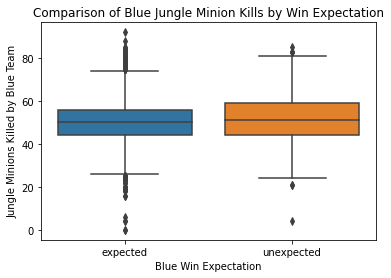

In [111]:
sns.boxplot(x="blueUnexpectedWin", y="blueTotalJungleMinionsKilled", data=lol)
plt.xlabel("Blue Win Expectation")
plt.ylabel("Jungle Minions Killed by Blue Team")
plt.title("Comparison of Blue Jungle Minion Kills by Win Expectation")
plt.show()

In [112]:
t_test_table(lol, team="red")

,"red expected win, avg","red unexpected win, avg",t statistic,adjusted p value
blueWardsPlaced,22.124147,23.436084,-2.394789,0.016648
blueWardsDestroyed,2.800995,2.991909,-2.887526,0.003891
blueFirstBlood,0.487794,0.623786,-8.979926,0.000000
blueKills,5.998959,7.477346,-16.362292,0.000000
blueDeaths,6.329747,4.794498,17.470991,0.000000
blueAssists,6.408423,8.300162,-15.489108,0.000000
blueEliteMonsters,0.548189,0.562298,-0.741666,0.458307
blueDragons,0.362953,0.355178,0.531950,0.594773
blueHeralds,0.185237,0.207120,-1.842005,0.065504
blueTowersDestroyed,0.052759,0.042071,1.438365,0.150362


Again, same story with red team, which is to be expected. 

Overall I would say this table does not provide insight into unexpected wins, which answers the question posed earlier (can we see any early signs of unexpected win in the dataset?) in the negative.

# Predicting Wins

Can the winner be determined from the data obtained in the first 10 minutes of a game? Based on the analysis of unexpected wins above, it seems like any model we build on this dataset to predict a winner will struggle with the unexpected wins. Let's try anyway.

Since the target variable `blueWins` is binary and the rest of the features are numeric, standard supervised learning models will work well. I will test logistic regression, K-nearest-neighbors, support vector machines,
decision trees, and random forests. 

To test each model I will run a 5-fold cross-validation. To score a model I will look at accuracy, precision, recall, F1 score, and area under the ROC curve (roc_auc). Since the prediction is a game win, false positives and false negatives are not incredibly costly, so accuracy will be the main focus, with the others serving as backups.

In [113]:
# define the cross-validation splits so each model is trained on the same splits 
cv_folds = KFold(n_splits=5, shuffle=True, random_state=1)

def run_cv(model, X, y, folds=cv_folds):
    """
    This function runs cross validation on the given model and data.
    """ 
    return cross_validate(model, 
                          X, y, 
                          cv=folds,
                          scoring=["accuracy", "precision", "recall", "f1", "roc_auc"]
                         )
    
    
def view_cv_results(cv_results):
    """
    Converts the cross-validation results into a readable table.
    """ 
    # color map for values in the table
    cm = sns.light_palette("green", as_cmap=True)
    
    # make the dataframe from the input dict
    df = pd.DataFrame(cv_results)
    
    # reformatting the index column
    df["fold"] = pd.Series(["Fold " + str(i) for i in range(1, len(df)+1)])
    df.set_index("fold", inplace=True)
    df.index.name = None 
    
    return df.style.background_gradient(cmap=cm)

def cv_conf_int(cv_results):
    """
    Uses the cross-validation results to create a confidence interval for each metric.
    """
    for metric in cv_results.keys():
        print(str(metric) + ": %0.2f (+/- %0.2f)" % (cv_results[metric].mean(), 2 * cv_results[metric].std()))

## Distance-Based Models


For these models it will be helpful to normalize the data since they work with Euclidean distances.

In [114]:
# get numeric columns 
numeric_cols = lol.drop(["blueWins", "blueUnexpectedWin", "redUnexpectedWin", "blueWardsPlaced", "redWardsPlaced"], axis=1).columns

# standardize the numeric columns
scaler = StandardScaler()
X = scaler.fit_transform(lol[numeric_cols])
y = lol["blueWins"]

### Logistic Regression

In [115]:
logreg = {}
logreg["model"] = LogisticRegression()  
logreg["results"] = run_cv(logreg["model"], X, y) 
view_cv_results(logreg["results"])

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
Fold 1,0.027701,0.005838,0.735830,0.727364,0.742300,0.734756,0.815876
Fold 2,0.019544,0.004535,0.741397,0.755374,0.730693,0.742828,0.819015
Fold 3,0.023228,0.004636,0.718117,0.735232,0.694915,0.714505,0.796011
Fold 4,0.019005,0.004461,0.725709,0.718466,0.730256,0.724313,0.806689
Fold 5,0.020740,0.005305,0.728608,0.718182,0.734504,0.726251,0.810700


In [116]:
cv_conf_int(logreg["results"])

fit_time: 0.02 (+/- 0.01)
score_time: 0.00 (+/- 0.00)
test_accuracy: 0.73 (+/- 0.02)
test_precision: 0.73 (+/- 0.03)
test_recall: 0.73 (+/- 0.03)
test_f1: 0.73 (+/- 0.02)
test_roc_auc: 0.81 (+/- 0.02)


### K-Nearest Neighbors

First let's identify an appropriate value of k, the number of neighbors. I will make an 80/20 train/test split and plot accuracy on the test set for varying values of k.

![alt_text](n_neighbors.jpg "Accuracies over different folds")

Seems like the best value for k is round 16; after this point the accuracy does not really improve. There is also a lot of variability in performance due to the choice of random seed.

In [117]:
knn = {}
knn["model"] = KNeighborsClassifier(n_neighbors=16)
knn["results"] = run_cv(knn["model"], X, y)
view_cv_results(knn["results"]) 

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
Fold 1,0.074140,1.158215,0.717105,0.728273,0.679671,0.703133,0.792212
Fold 2,0.027902,1.210096,0.699899,0.724435,0.666337,0.694172,0.783717
Fold 3,0.053285,1.153493,0.706478,0.741163,0.648056,0.691489,0.771278
Fold 4,0.062594,1.140929,0.718117,0.725702,0.689231,0.706996,0.782146
Fold 5,0.058818,1.147739,0.686582,0.698974,0.633264,0.664499,0.768514


In [118]:
cv_conf_int(knn["results"])

fit_time: 0.06 (+/- 0.03)
score_time: 1.16 (+/- 0.05)
test_accuracy: 0.71 (+/- 0.02)
test_precision: 0.72 (+/- 0.03)
test_recall: 0.66 (+/- 0.04)
test_f1: 0.69 (+/- 0.03)
test_roc_auc: 0.78 (+/- 0.02)


### Support vector machine

In [119]:
svc = {}
svc["model"] = SVC(kernel="linear")
svc["results"] = run_cv(svc["model"], X, y)
view_cv_results(svc["results"])

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
Fold 1,3.031297,0.300175,0.733806,0.727181,0.736140,0.731633,0.815829
Fold 2,3.186107,0.293045,0.738866,0.754115,0.725743,0.739657,0.819535
Fold 3,3.299809,0.288895,0.718117,0.737234,0.690927,0.713330,0.795119
Fold 4,3.113662,0.297077,0.727733,0.720930,0.731282,0.726069,0.805736
Fold 5,3.073938,0.321080,0.726582,0.717923,0.728306,0.723077,0.810027


In [120]:
cv_conf_int(svc["results"])

fit_time: 3.14 (+/- 0.19)
score_time: 0.30 (+/- 0.02)
test_accuracy: 0.73 (+/- 0.01)
test_precision: 0.73 (+/- 0.03)
test_recall: 0.72 (+/- 0.03)
test_f1: 0.73 (+/- 0.02)
test_roc_auc: 0.81 (+/- 0.02)


## Non-Distance-Based Models

For these models, distances between datapoints are not going to affect the training process, so we can just use the unscaled data.

In [121]:
X = lol[numeric_cols]
y = lol["blueWins"]

### Decision Tree

This model is nice for interpretability. I will limit the depth of the tree to 3 to avoid overfitting.

In [122]:
dectree = {}
dectree["model"] = DecisionTreeClassifier(random_state=1, max_depth=3)
dectree["results"] = run_cv(dectree["model"], X, y)
view_cv_results(dectree["results"])

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
Fold 1,0.025747,0.012722,0.732794,0.729424,0.727926,0.728674,0.801400
Fold 2,0.026308,0.007574,0.718117,0.744337,0.683168,0.712442,0.794667
Fold 3,0.025391,0.008995,0.711538,0.739756,0.666002,0.700944,0.781756
Fold 4,0.026874,0.008977,0.722166,0.733553,0.686154,0.709062,0.791921
Fold 5,0.026361,0.009353,0.728101,0.732973,0.700413,0.716323,0.800122


In [123]:
cv_conf_int(dectree["results"])

fit_time: 0.03 (+/- 0.00)
score_time: 0.01 (+/- 0.00)
test_accuracy: 0.72 (+/- 0.01)
test_precision: 0.74 (+/- 0.01)
test_recall: 0.69 (+/- 0.04)
test_f1: 0.71 (+/- 0.02)
test_roc_auc: 0.79 (+/- 0.01)


### Random Forest

In [124]:
rfc = {}
rfc["model"] = RandomForestClassifier(max_depth = 3, n_estimators = 100)
rfc["results"] = run_cv(rfc["model"], X, y)
view_cv_results(rfc["results"])

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
Fold 1,0.440198,0.039185,0.735324,0.729400,0.736140,0.732754,0.810185
Fold 2,0.426498,0.035953,0.728745,0.739394,0.724752,0.732000,0.809530
Fold 3,0.388323,0.036284,0.712551,0.732124,0.683948,0.707216,0.791413
Fold 4,0.418346,0.039987,0.726721,0.719475,0.731282,0.725331,0.804414
Fold 5,0.409754,0.036480,0.735190,0.731530,0.726240,0.728875,0.809689


In [125]:
cv_conf_int(rfc["results"])

fit_time: 0.42 (+/- 0.03)
score_time: 0.04 (+/- 0.00)
test_accuracy: 0.73 (+/- 0.02)
test_precision: 0.73 (+/- 0.01)
test_recall: 0.72 (+/- 0.04)
test_f1: 0.73 (+/- 0.02)
test_roc_auc: 0.81 (+/- 0.01)


## Model Selection

Turns out most of these models perform similarly. Since the decision tree works well and gives an interpretable result, I would recommend using it for a final model to draw insight from.

Here is a plot of the decision tree on the whole dataset. This tree gives us a lot of information about how the model classifies a game.

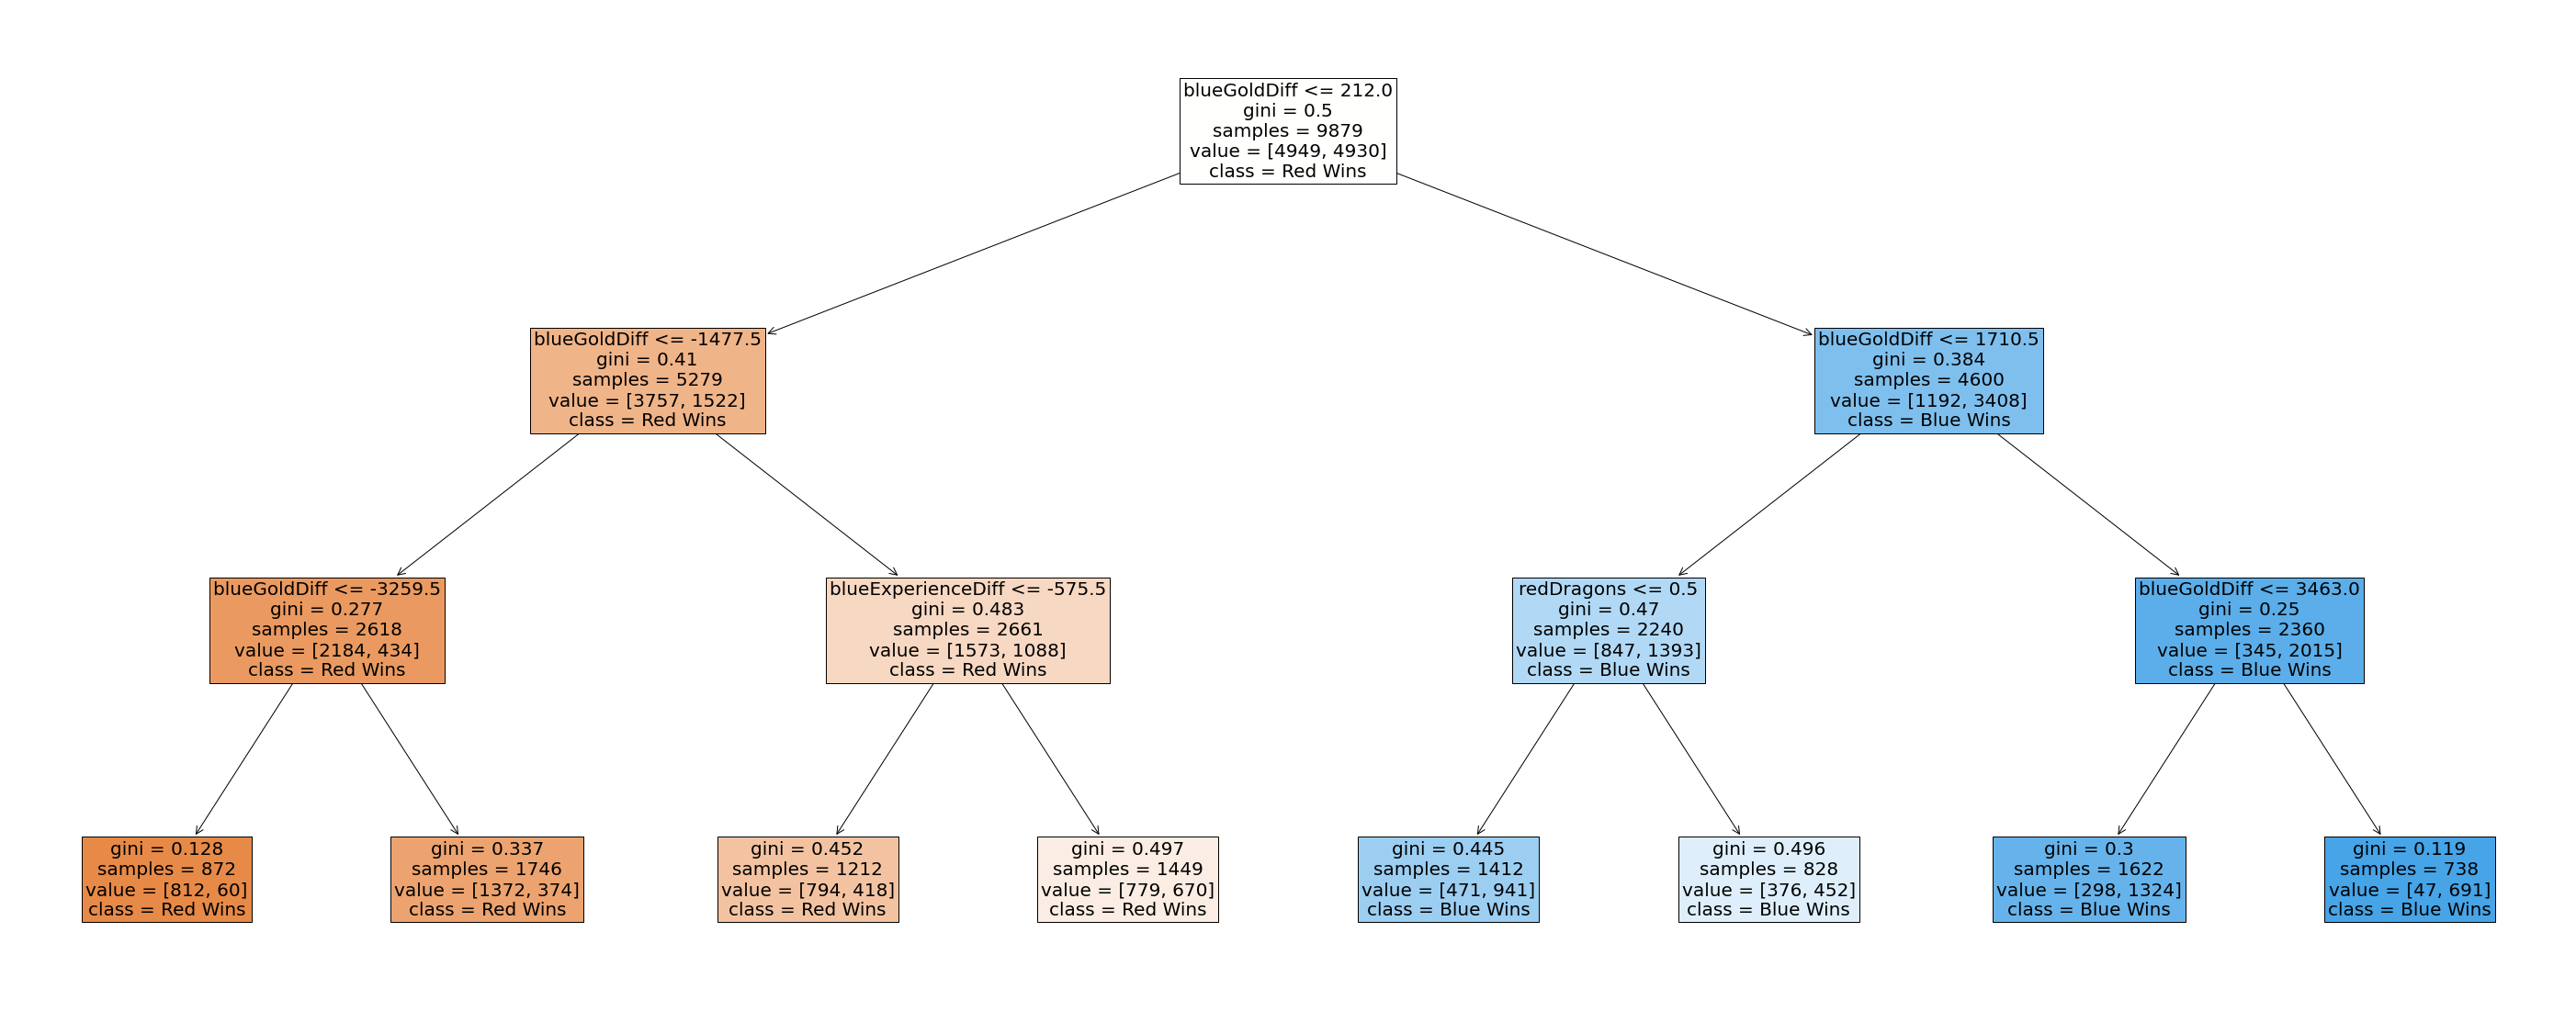

In [126]:
dectree["model"].fit(X, y)
plt.figure(figsize=(50,20))
plot_tree(dectree["model"], 
          feature_names = X.columns,
          class_names = ["Red Wins", "Blue Wins"],
          fontsize=20,
          filled=True
         )
plt.show()

## Do unexpected wins correspond with misclassifications?

In [129]:
# define a new column in the data to keep track of misclassified datapoints.
def is_correctly_classified(model, x, y):
    """
    return true or false for misclassified.
    """
    pred = model.predict(x.to_numpy().reshape(1, -1))[0]
    
    return y==pred

lol["correctly_classified"]=lol.apply(lambda x: is_correctly_classified(dectree["model"], x[numeric_cols], x["blueWins"]), axis=1)
lol["unexpectedWin"] = unexpected_win.apply(lambda x: "unexpected" if x else "expected")

In [138]:
lol[["blueWins", "unexpectedWin", "correctly_classified"]].\
    groupby(["unexpectedWin", "correctly_classified"]).count()/len(lol)

blueWins
unexpectedWin correctly_classified          
expected      False                 0.071971
              True                  0.680939
unexpected    False                 0.202753
              True                  0.044336

This table shows the percentages of each combination of win expectation and classification, and it confirms that the decision tree gets more of the expected games correct than it does the unexpected games. Indeed, this table says that 68% of games followed the win expectation and were correctly predicted, while 20% went against the expectation and were incorrectly predicted. 

This observation just about lines up with the prediction accuracy (72%).
Moreover, judging by the decision tree plot above, the most important factor for the model is the gold difference between the teams (followed by experience difference and dragon kills). 
Referring back to the yellow t-test tables above, this should be no surprise: there is a significant (both practical and statistical) difference in the gold difference between expected and unexpected games, so this classifier is going to struggle with predicting these unexpected wins. 

# Future Directions

From here it might be interesting to look at what's going on in those other two categories: 
those games where the expected-to-win team were misclassified by the model, and those games
where the underdog won and were correctly predicted to win.

Another possiblity for extending this project is to use the Riot API to gather more data or 
more features for these games. How much of this holds true in lower-ranked games?